<a href="https://colab.research.google.com/github/Abhi12122000/TD3_multi_agent_uav-/blob/main/TD3_UAV_Single_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twin-Delayed DDPG

## Installing the packages

In [1]:
!pip install pybullet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.7/91.7 MB 10.5 MB/s eta 0:00:00


In [2]:
!pip install gym==0.15.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 77.9 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.15.3-py3-none-any.whl size=1644968 sha256=73d5531b8bb7e872e29346a5cc4797d9dbc5f7e62da1b57bc30ed8f1185d55b6
  Stored in directory: /root/.cache/pip/wheels/9b/b4/52/f4cce4bdc360a2289a3433deaa062ceb13dbe429c342866e97
Successfully built gym
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 2.2.0
    Uninstalling cloudpickle-2.2.0:
      Successfully uninstalled cloudpickle-2.2.0
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. Thi

## Importing the libraries

In [3]:
import os
import time
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pybullet_envs
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from gym import wrappers, Env, spaces
from torch.autograd import Variable
from collections import deque

## Step 1: Initializing Experience Replay memory

In [4]:
class ReplayBuffer(object):

  def __init__(self, max_size=1e6):
    self.storage = []
    self.max_size = max_size
    self.ptr = 0

  def add(self, transition, num_instances = 1):
    for i in range(num_instances):
      if len(self.storage) == self.max_size:
        self.storage[int(self.ptr)] = transition
      else:
        self.storage.append(transition)
      self.ptr = int((self.ptr + 1) % self.max_size)  
        

  def sample(self, batch_size, random = True):
    if random:
      ind = np.random.randint(0, len(self.storage), size=batch_size)
    else:
      beg_idx = max(self.ptr - batch_size, 0)
      remaining_sample_count = self.ptr - beg_idx
      ind = []
          
      if self.ptr > 0:
        ind = [i for i in range(beg_idx, self.ptr)]
      
      if remaining_sample_count > 0:
        for i in range(len(self.storage)-remaining_sample_count, len(self.storage)):
          ind.append(i)
      num_repeats = int(math.ceil(batch_size // len(self.storage)))
      if num_repeats > 1:
        temp_array = []
        for _ in range(num_repeats):
          for j in ind:
            temp_array.append(j)
        ind = temp_array[:batch_size]
      ind = np.array(ind)
      # print(ind)
    
    batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones = [], [], [], [], []
    for i in ind: 
      state, next_state, action, reward, done = self.storage[i]
      batch_states.append(np.array(state, copy=False))
      batch_next_states.append(np.array(next_state, copy=False))
      batch_actions.append(np.array(action, copy=False))
      batch_rewards.append(np.array(reward, copy=False))
      batch_dones.append(np.array(done, copy=False))
    return np.array(batch_states), np.array(batch_next_states), np.array(batch_actions), np.array(batch_rewards).reshape(-1, 1), np.array(batch_dones).reshape(-1, 1)


## Step 2: Actor Critic Networks

In [5]:
# Selecting the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
class Actor(nn.Module):
  
  def __init__(self, state_dim, action_dim, max_action, min_action):
    super(Actor, self).__init__()
    self.layer_1 = nn.Linear(state_dim, 400)
    self.layer_2 = nn.Linear(400, 300)
    self.layer_3 = nn.Linear(300, action_dim)
    self.max_action = torch.from_numpy(max_action).to(device)
    self.min_action = torch.from_numpy(min_action).to(device)

  def forward(self, x):
    x = F.relu(self.layer_1(x))
    x = F.relu(self.layer_2(x))
    # print("actor output: ", torch.tanh(self.layer_3(x)))
    x = torch.tanh(self.layer_3(x))
    # x = (((self.max_action - self.min_action) * (torch.tanh(self.layer_3(x)) + 1)) / 2) + self.min_action
    # print("actor output SCALED: ", x) 
    return x

In [7]:
class Critic(nn.Module):
  
  def __init__(self, state_dim, action_dim, critic_min_output = -1000, critic_max_output = 1000):
    super(Critic, self).__init__()
    # Defining the first Critic neural network
    self.layer_1 = nn.Linear(state_dim + action_dim, 400)
    self.layer_2 = nn.Linear(400, 300)
    self.layer_3 = nn.Linear(300, 1)
    # Defining the second Critic neural network
    self.layer_4 = nn.Linear(state_dim + action_dim, 400)
    self.layer_5 = nn.Linear(400, 300)
    self.layer_6 = nn.Linear(300, 1)
    self.critic_min_output = critic_min_output
    self.critic_max_output = critic_max_output

  def forward(self, x, u):
    xu = torch.cat([x, u], 1)
    # Forward-Propagation on the first Critic Neural Network
    x1 = F.relu(self.layer_1(xu))
    x1 = F.relu(self.layer_2(x1))
    # x1 = self.layer_3(x1)

    # TESTING CODE (Limiting network output)
    x1 = (((self.critic_max_output - self.critic_min_output) * (torch.tanh(self.layer_3(x1)) + 1)) / 2) + self.critic_min_output
    # TESTING CODE ENDS

    # Forward-Propagation on the second Critic Neural Network
    x2 = F.relu(self.layer_4(xu))
    x2 = F.relu(self.layer_5(x2))
    # x2 = self.layer_6(x2)

    # TESTING CODE (Limiting network output)
    x2 = (((self.critic_max_output - self.critic_min_output) * (torch.tanh(self.layer_6(x2)) + 1)) / 2) + self.critic_min_output
    # TESTING CODE ENDS

    return x1, x2

  def Q1(self, x, u):
    xu = torch.cat([x, u], 1)
    x1 = F.relu(self.layer_1(xu))
    x1 = F.relu(self.layer_2(x1))
    # x1 = self.layer_3(x1)

    # TESTING CODE (Limiting network output)
    x1 = (((self.critic_max_output - self.critic_min_output) * (torch.tanh(self.layer_3(x1)) + 1)) / 2) + self.critic_min_output
    # TESTING CODE ENDS
    return x1

## Step 3: TD3 Training Class

TODO: See how to improve noise addition to the target action

In [8]:
# Building the whole Training Process into a class

class TD3(object):
  
  def __init__(self, state_dim, action_dim, max_action, min_action, critic_min_output = -1000, critic_max_output = 1000):
    self.actor = Actor(state_dim, action_dim, max_action, min_action).to(device)
    odd = True
    for param in self.actor.parameters():
        # print(param.size())
        if(odd):
            nn.init.xavier_normal_(param, gain=1.0)
            odd = False
        else:
            odd = True
    self.actor_target = Actor(state_dim, action_dim, max_action, min_action).to(device)
    self.actor_target.load_state_dict(self.actor.state_dict())
    self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr = learning_rate)
    self.critic = Critic(state_dim, action_dim).to(device)
    odd = True
    for param in self.critic.parameters():
        # print(param.size())
        if(odd):
            nn.init.xavier_normal_(param, gain=1.0)
            odd = False
        else:
            odd = True
    # nn.init.xavier_uniform_(self.critic.parameters(), gain=1.0)
    self.critic_target = Critic(state_dim, action_dim).to(device)
    self.critic_target.load_state_dict(self.critic.state_dict())
    self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr = learning_rate)
    self.max_action = torch.from_numpy(max_action).to(device)
    self.min_action = torch.from_numpy(min_action).to(device)


  def select_action(self, state):
    state = torch.Tensor(state.reshape(1, -1)).to(device)
    return self.actor(state).cpu().data.numpy().flatten()  # if this ".cpu()" is not included, this error is thrown:- 
                                                           # TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.


  # def squash_actor_output(self, action):
  #     '''
  #     Incomplete Function
  #     '''
  #     x = (((self.max_action - self.min_action) * (torch.tanh(self.layer_3(x)) + 1)) / 2) + self.min_action
  #     pass

  def train(self, replay_buffer, iterations=1, batch_size=25, discount=0.99, tau=0.005, policy_noise=0.2, noise_clip=0.5, policy_freq=4):
    

    # # Testing Code for checking effect of batch_size on training
    # batch_size = 1
    # # End of Testing Code 
    # print("---------------------------entered training step---------------------------")
    for it in range(iterations):
      
      # Step 4: We sample a batch of transitions (s, s’, a, r) from the memory
      batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones = replay_buffer.sample(batch_size, random = False)
      state = torch.Tensor(batch_states).to(device)
      next_state = torch.Tensor(batch_next_states).to(device)
      action = torch.Tensor(batch_actions).to(device)
      reward = torch.Tensor(batch_rewards).to(device)
      done = torch.Tensor(batch_dones).to(device)
      
      # Step 5: From the next state s’, the Actor target plays the next action a’
      next_action = self.actor_target(next_state)
      
      # # Step 6: We add Gaussian noise to this next action a’ and we clamp it in a range of values supported by the environment
      # noise = torch.Tensor(batch_actions).data.normal_(0, policy_noise).to(device)
      # noise = noise.clamp(-noise_clip, noise_clip)
      # next_action = (next_action + noise).clamp(self.min_action, self.max_action)
      
      # TESTING CODE (Removing Exploration Noise)
      next_action = (next_action).clamp(self.min_action, self.max_action)
      # TESTING CODE ENDS

      # Step 7: The two Critic targets take each the couple (s’, a’) as input and return two Q-values Qt1(s’,a’) and Qt2(s’,a’) as outputs
      target_Q1, target_Q2 = self.critic_target(next_state, next_action)
      
      # Step 8: We keep the minimum of these two Q-values: min(Qt1, Qt2)
      target_Q = torch.min(target_Q1, target_Q2)
      
      # Step 9: We get the final target of the two Critic models, which is: Qt = r + γ * min(Qt1, Qt2), where γ is the discount factor
      target_Q = reward + ((1 - done) * discount * target_Q).detach()
      
      # Step 10: The two Critic models take each the couple (s, a) as input and return two Q-values Q1(s,a) and Q2(s,a) as outputs
      current_Q1, current_Q2 = self.critic(state, action)
      # print("Q1: ", current_Q1, ", Q2: ", current_Q2, ", target Q: ", target_Q)
      # Step 11: We compute the loss coming from the two Critic models: Critic Loss = MSE_Loss(Q1(s,a), Qt) + MSE_Loss(Q2(s,a), Qt)
      critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)
      # critic_loss /= 10
      # print("critic loss new: ", critic_loss)
      # if(total_timesteps % 5000 == 0):
      #     print("timesteps: ", total_timesteps, ", critic loss: ", critic_loss)
      
      # Step 12: We backpropagate this Critic loss and update the parameters of the two Critic models with a SGD optimizer
      self.critic_optimizer.zero_grad()
      critic_loss.backward()
      self.critic_optimizer.step()
      
      # Step 13: Once every two iterations, we update our Actor model by performing gradient ascent on the output of the first Critic model
      if it % policy_freq == 0:
        actor_loss = -self.critic.Q1(state, self.actor(state)).mean()
        # # TESTING CODE BEGINS (removing minus sign in actor loss)
        # actor_loss = self.critic.Q1(state, self.actor(state)).mean()
        # # TESTING CODE ENDS
        # if(total_timesteps % 5000 == 0):
        #     print("timesteps: ", total_timesteps, ", actor loss: ", actor_loss)
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        print("----------------------reached training----------------------")
        print("critic loss: ", critic_loss)
        print("actor loss: ", actor_loss)
        self.actor_optimizer.step()
        
        # Step 14: Still once every two iterations, we update the weights of the Actor target by polyak averaging
        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
          target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
        
        # Step 15: Still once every two iterations, we update the weights of the Critic target by polyak averaging
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
          target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
    # print("---------------------------ending training step---------------------------")
  
  # Making a save method to save a trained model
  def save(self, filename, directory):
    torch.save(self.actor.state_dict(), '%s/%s_actor.pth' % (directory, filename))
    torch.save(self.critic.state_dict(), '%s/%s_critic.pth' % (directory, filename))
  
  # Making a load method to load a pre-trained model
  def load(self, filename, directory):
    self.actor.load_state_dict(torch.load('%s/%s_actor.pth' % (directory, filename)))
    self.critic.load_state_dict(torch.load('%s/%s_critic.pth' % (directory, filename)))

## Helper Evaluation Functions

In [9]:
def evaluate_policy(policy, eval_episodes=10, highest_reward = -10000000):
  '''
  Function that evaluates the policy by calculating its average reward over 10 episodes
  '''
  # print("Evaluating now")
  avg_reward = 0.
  for _ in range(eval_episodes):
    this_reward = 0.
    obs = env.reset()
    # print("state after env reset: ", obs)
    done = False
    i = 0
    while not done:
      i += 1
      action = policy.select_action(np.array(obs))
      # print("action: ", action)
      # print("P_t selected by action: ", action[3])
      #print(action)
      obs, reward, done, _ = env.step(action)
      highest_reward = max(highest_reward, reward)
      # print("step over")
      this_reward += reward
    avg_reward += (this_reward / i)
  avg_reward /= eval_episodes
  # Commenting for TESTING
  print ("---------------------------------------")
  print ("Average Reward over the Evaluation Step: %f" % (avg_reward))
  print ("---------------------------------------")
  # Commenting for TESTING
  # print("Evaluation done!")
  return avg_reward

In [10]:
def run_random_episode(policy):
    '''
    Helper function to visualize training
    This function runs an entire episode using the policy output by the actor network, \
    and plots the UAV position graph at 10 equally spaced timesteps. 
    '''
    obs = env.reset()
    gap_ = int(max_episode_steps // 10)
    done = False
    i = 0
    fig, axes = plt.subplots(10, 2, figsize=(10, 100))
    while not done:
        action = policy.select_action(np.array(obs))
        if((i % gap_ == 0) and ((i / gap_) < 10)):
            env.render(fig = fig, ax = axes, i = int(i // gap_))
        obs, reward, done, _ = env.step(action)
        i += 1
    return

### Training Parameters

In [11]:
seed = 0 # Random seed number
start_timesteps = 9990 # 2e4 # 5e3 # Number of iterations/timesteps before which the model randomly chooses an action, and after which it starts to use the policy network
eval_freq = 1 # 200 # How often the evaluation step is performed (after how many timesteps)
max_timesteps = 10000 # 6e4 # Total number of iterations/timesteps
save_models = True # Boolean checker whether or not to save the pre-trained model
expl_noise = 0 # 0.1 # Exploration noise - STD value of exploration Gaussian noise
batch_size = 100 # Size of the batch
discount = 0.99 # Discount factor gamma, used in the calculation of the total discounted reward
tau = 0.005 # Target network update rate
policy_noise = 0.2 # STD of Gaussian noise added to the actions for the exploration purposes
noise_clip = 0.5 # Maximum value of the Gaussian noise added to the actions (policy)
policy_freq = 1 # Number of iterations to wait before the policy network (Actor model) is updated
max_episode_steps = 1 # 25 # Maximum number of steps in a single episode, after which environment returns done = True
num_episodes = int(max_timesteps // max_episode_steps) # Total number of training episodes
learning_rate = 1e-6
total_episodes = int(max_timesteps // max_episode_steps) 
buffer_size = 1e5 # Maximum buffer capacity
optimizer_type = "AdamOptimizer"
env_name = "custom_UAV_Single_Agent"

### Saving the Model

In [12]:
# create a file name for the two saved models: the Actor and Critic models
file_name = "%s_%s_%s" % ("TD3", env_name, str(seed))
print ("---------------------------------------")
print ("Settings: %s" % (file_name))
print ("---------------------------------------")


# create a folder inside which will be saved the trained models
if not os.path.exists("./results"):
  os.makedirs("./results")
if save_models and not os.path.exists("./pytorch_models"):
  os.makedirs("./pytorch_models")

---------------------------------------
Settings: TD3_custom_UAV_Single_Agent_0
---------------------------------------


## Single Agent UAV Environment Creation

In [13]:
# Environment Parameters

UE_seed = 1
UE_count = 40
EC_count = 1
C_min = 100
C_max = 200
D_m_min = 1e6 # in bits
D_m_max = 5e6 # in bits
Z_max = 40
Z_min = 20
L_h_max = 49
L_v_max = 12
D_min = 100
lambda_m = 1
phi_n = np.radians(42.44)  # in degrees
g_0 = 1e-5 # in power gain # -50 in dB
B_u = 10 * 1e6  # in Hz
B_k = 0.5 * 1e6  # in Hz
P_max = 5
P_m = 0.1
P_r_n = 0.1
F_u = 3e9 # in Hz
F_e_k_max = 9e9 # in Hz
F_e_k_min = 6e9 # in Hz
kappa = (1e-28) # check if float maintains this precision
sigma_squared_u = (1e-13) # in watt # -100 in dBm
sigma_squared_e = (1e-13) # in watt # -100 in dBm
w1 = w2 = 1
eta_1 = 5
eta_2 = 5
eta_3 = 5
boundary_x = boundary_y = 150.

reward_baseline_fraction_of_UEs_covered = 1.0

# plotting parameters
plotting_boundary_buffer = 5.
UAV_coverage_circle_color = 'lavender'
EC_concentrated_region_color = 'mistyrose'
UAV_path_color = 'green'

In [14]:
# Environment and Network Bounds

action_space_coversion_lb = np.zeros(4 + (EC_count * UE_count))
action_space_coversion_lb[2] = -L_v_max
action_space_coversion_lb[3] = 1e-2
action_space_coversion_ub = np.ones(4 + (EC_count * UE_count))
action_space_coversion_ub[0:4] = np.array([L_h_max, 2 * math.pi, L_v_max, P_max]) 

action_space_lb = -1 * np.ones(4 + (EC_count * UE_count))
action_space_ub = np.ones(4 + (EC_count * UE_count))
state_space_lb = np.array([0, 0, Z_min])
state_space_ub = np.array([boundary_x, boundary_y, Z_max])
critic_min_output = -50
critic_max_output = 50

In [44]:
# Environment Class

class Single_Agent_UAV(Env):
    def __init__(self, initial_UAV_state = None):
        '''
        Initializes necessary parameters of environment (UE_positions, UAV_initial_position, EC_positions, D_array, C_array, etc.) 
        '''
        super(Single_Agent_UAV, self).__init__()
#         self.state_shape = 
#         defining action space
        self.state_space = gym.spaces.box.Box(low = state_space_lb, high = state_space_ub)
#         defining observation space
        self.action_space = gym.spaces.box.Box(low = action_space_lb, high = action_space_ub)
        
        self.timesteps_in_episode = 0
        self.done = False
        self.last_action = self.action_space.sample()

        self.UE_positions = []
        self.EC_positions = []
        self.EC_F_e_k = []
        self.D_array = []
        self.C_array = []
#         initialize grid dimensions (400 x 400) 
        if initial_UAV_state is not None:
          self.current_state = np.array(initial_UAV_state)
        else:
          self.current_state = self.select_random_state()
        
        self.initial_UAV_state = self.current_state
        
        self.previous_state = self.current_state
        print("initial state of UAV: ", self.current_state)
    
#         call function to place UEs on the grid and specify (D_m, C_m, lambda_m) for UAVs
        self.place_UEs(position="centered", desired_z_coord = (Z_min + Z_max) / 2, center = None)
        self.place_ECs_randomly()


    def render_UAV_movement_through_episode(self, **kwargs):
        '''
        Helper function to visualize UAV movement through an episode
        Arguments: A list specifying UAV positions throughout the episode
        '''

        if 'reward' not in kwargs:
            kwargs['reward'] = 'Not known'
        
        C_max_t = (kwargs['UAV_positions_list'][-1][2] / np.tan(phi_n))
        buffer = 5.
        if 'fig' not in kwargs:
            fig, ax = plt.subplots(1, figsize=(10,10))
            ax = np.array([ax])
            i = 0
        else:
            fig = kwargs['fig']
            ax = kwargs['ax']
            i = kwargs['i']

        ax[i].set_xlim(-buffer, boundary_x+buffer)
        ax[i].set_ylim(-buffer, boundary_y+buffer)
        ax[i].grid()
        UE_x = self.UE_positions[:, 0]
        UE_y = self.UE_positions[:, 1]
        ax[i].plot(UE_x, UE_y, color='black', marker='o', markersize=6, linestyle = '', label = "UE")
        
        EC_x = self.EC_positions[:, 0]
        EC_y = self.EC_positions[:, 1]
        ax[i].plot(EC_x, EC_y, color='red', marker='D', markersize=7, linestyle = '', label = "EC")
        
        ax[i].plot(np.array(kwargs['UAV_positions_list'])[:, 0] , np.array(kwargs['UAV_positions_list'])[:, 1], color=UAV_path_color, markersize=6, linestyle = '-', label = "UAV Path Color")
        ax[i].plot(kwargs['UAV_positions_list'][-1][0], kwargs['UAV_positions_list'][-1][1], color='blue', marker='x', markersize=9, linestyle = '', label = "UAV ending position")
        
      # For testing: To plot the circle and visualize UE points inside it
        if self.UE_center is not None:
            Test_UE_allotment_circle = plt.Circle((self.UE_center[0] , self.UE_center[1]), self.UE_radius, color = EC_concentrated_region_color)
            ax[i].add_artist(Test_UE_allotment_circle)
      # End
      
        UAV_coverage_area = plt.Circle((kwargs['UAV_positions_list'][-1][0], kwargs['UAV_positions_list'][-1][1]), C_max_t, color = UAV_coverage_circle_color)
        ax[i].add_artist(UAV_coverage_area)
      

        ax[i].set_aspect(1)
        # naming the x axis
        ax[i].set_xlabel('X pos (m)')
        # naming the y axis
        ax[i].set_ylabel('Y pos (m)')
        title_str = 'UAV movement through episode'
        if 'episode_num' in kwargs:
            title_str += ', episode: ' + str(kwargs['episode_num'])
        ax[i].set_title(title_str)
        # giving a title to my graph
        # plt.title('Visually Appealing!')

        # show a legend on the plot
        ax[i].legend()
        # plt.show()
        return


    def render_bar_plot(self, ax, plot_number, idx):
        '''
        Plotting bar graph of each UE's fraction of tasks assigned to UAV and to EC, by the last action input given to step() function
        '''
        x_indices = np.arange(UE_count)
        width = 0.5

        gamma_array = (np.array(self.last_action[4:])).reshape((UE_count, EC_count))
        gamma_zeros = (1 - gamma_array.sum(axis = 1))
        
        ax[plot_number, idx].bar(x_indices, gamma_zeros, width=width)
        for i in range(EC_count):
            ax[plot_number, idx].bar(x_indices, gamma_array[:, i], width=width)
        
    
    def render_position_plot(self, ax, plot_number, idx, reward):
        '''
        Helper function to render(), plots the current position plot on given axes. 
        Plotting position plot of UAV's current position and coverage
        '''

        C_max_t = (self.current_state[2] / np.tan(phi_n))
        buffer = 5.
        ax[plot_number, idx].set_xlim(-buffer, boundary_x+buffer)
        ax[plot_number, idx].set_ylim(-buffer, boundary_y+buffer)
        ax[plot_number, idx].grid()
        UE_x = self.UE_positions[:, 0]
        UE_y = self.UE_positions[:, 1]
        ax[plot_number, idx].plot(UE_x, UE_y, color='black', marker='o', markersize=6, linestyle = '', label = "UE")
        
        EC_x = self.EC_positions[:, 0]
        EC_y = self.EC_positions[:, 1]
        ax[plot_number, idx].plot(EC_x, EC_y, color='red', marker='D', markersize=7, linestyle = '', label = "EC")
        
        ax[plot_number, idx].plot(self.current_state[0], self.current_state[1], color='blue', marker='x', markersize=9, linestyle = '', label = "UAV")
        
      # For testing: To plot the circle and visualize UE points inside it
        if self.UE_center is not None:
            Test_UE_allotment_circle = plt.Circle((self.UE_center[0] , self.UE_center[1]), self.UE_radius, color = EC_concentrated_region_color)
            ax[plot_number, idx].add_artist(Test_UE_allotment_circle)
      # End
        UAV_coverage_area = plt.Circle((self.current_state[0] , self.current_state[1] ), C_max_t, color = UAV_coverage_circle_color)
        ax[plot_number, idx].add_artist(UAV_coverage_area)
      

        ax[plot_number, idx].set_aspect(1)
        # naming the x axis
        ax[plot_number, idx].set_xlabel('X pos (m)')
        # naming the y axis
        ax[plot_number, idx].set_ylabel('Y pos (m)')
        ax[plot_number, idx].set_title('reward: ' + str(reward))
        # giving a title to my graph
        # plt.title('Visually Appealing!')

        # show a legend on the plot
        ax[plot_number, idx].legend()
        # plt.show()


    def render(self, **kwargs):
        '''
        Function to visualize UAV position
        (this function has different configurations for different use cases)
        '''

        if 'UAV_positions_list' in kwargs:
            self.render_UAV_movement_through_episode(**kwargs)
            return

        if 'fig' not in kwargs:
            fig, ax = plt.subplots(1, 2, figsize=(20,10))
            ax = np.array([ax])
            kwargs['fig'] = fig
            kwargs['ax'] = ax
            kwargs['i'] = 0
        
        if 'reward' not in kwargs:
            kwargs['reward'] = 'Not known'
        self.render_position_plot(kwargs['ax'], kwargs['i'], 0, kwargs['reward'])
        if(self.timesteps_in_episode != 0):
            self.render_bar_plot(kwargs['ax'], kwargs['i'], 1)
        return


    def reset(self):
        '''
        Resets the environment paramters to some initial values
        '''
#         we should only reassign the position of UAV here
        # Commenting for TESTING
        self.current_state = self.initial_UAV_state
        # Commenting for TESTING done

        # self.current_state = self.select_random_state()
        self.this_episode_UAV_positions_list = []
        # print("new initial state of UAV (after resetting): ", self.current_state)

        self.timesteps_in_episode = 0
        self.done = False
        return self.current_state
    
    
    def step(self, action):
        '''
        Takes action moving environment from current_state to next_state
        Arguments: `action` to be taken
        Returns: new_state, reward, done, info(=None)
        '''
        # print("printing action in step function: ", action)
        action = np.array(action)
        print("unscaled action: ", action)
#         action is of the form [l_n(t), v_n(t), del_z_n(t), P_t_n(t), gamma_0_1(t), ..., gamma_0_k(t), gamma_1_1(t), ..., gamma_1_k(t), ..., gamma_m_k(t)]
#         What happens if (sum of gamma_n_m_k != 1) ?
#         The above problem has been dealt by not including gamma_i_0(t) in predicted action.
#         Rather, we evaluate it as:- gamma_i_0(t) = 1 - summation(gamma_i_k(t))
        action = (((action_space_coversion_ub - action_space_coversion_lb) * (action + 1)) / 2) + action_space_coversion_lb
        print("scaled action: ", action)
        self.timesteps_in_episode += 1
        # print("P_t of action: ", action[3])
        action = self.move(action)
        print("scaled and clipped action: ", action)
        self.last_action = action
        # print("action after moving: ", action)
        
        gamma_array = (np.array(action[4:])).reshape((UE_count, EC_count))
        gamma_zeros = (1 - gamma_array.sum(axis = 1))
        # print("gamma zeros: ", gamma_zeros)
        
# REMOVED CODE
#         gamma_array = []
#         gamma_zeros = []
#         for i in range(len(self.UE_positions)):
#             base = 4
#             sum_gamma_i = 0
#             gamma_i_array = []
#             for j in range(EC_count):
#                 gamma_i_array.append(action[base + (i * EC_count) + j])
#                 sum_gamma_i += gamma_i_array[-1]
#             gamma_array.append(np.array(gamma_i_array))
#             gamma_zeros.append(1 - sum_gamma_i)
    
#         gamma_zeros = np.array(gamma_zeros)
#         gamma_array = np.array(gamma_array)
# END OF REMOVED CODE
        
#         calculate C_max_t for UAV (using correct formula)
        C_max_t = (self.current_state[2] / np.tan(phi_n))
        
        ground_UAV_state = np.zeros(3)
        ground_UAV_state[:2] = self.current_state[:2]
        horizontal_dist_UE_UAV = np.linalg.norm(self.UE_positions - ground_UAV_state, axis = 1)
        dist_UE_UAV = np.linalg.norm(self.UE_positions - self.current_state, axis = 1)
        # print("horizontal distance b/w UEs and UAV: ", horizontal_dist_UE_UAV)
        # print("distance b/w UEs and UAV: ", dist_UE_UAV)
        rho_array = (horizontal_dist_UE_UAV <= (C_max_t)) * 1  # binary association vector
        M_t = rho_array.sum()  # no. of UEs served by the agent
        
        # print("M_t: ", M_t, " C_max_t: ", C_max_t)
        
        try:
            if(M_t==0):
                raise ValueError("-----UAV serves no UEs in its present state-----")
        
        except ValueError:
            #Reward: 
            reward = coverage_penalty = -1 * (UE_count - M_t) * eta_3  # coverage constraint penalty
            # print("coverage penalty = reward:- ", coverage_penalty)
            # TESTING CODE (adding baseline to reward, i.e., if >= 50% UEs are covered, then reward is positive, otherwise negative)
            reward += (int(reward_baseline_fraction_of_UEs_covered * UE_count) * eta_3)
            # TESTING CODE ENDS
            self.is_done()
    
            # if(self.done):
            #   print("------------------------", "reward in episode's last step: ", reward, "------------------------")
            
            return self.current_state, reward, self.done, None
            
        
        dist_EC_UAV = np.linalg.norm(self.EC_positions - self.current_state, axis = 1)
        # print("distance b/w ECs and UAV: ", dist_EC_UAV)

# REMOVED CODE
#         for current_UE in self.UE_positions:
#             dist_i = np.linalg.norm(current_UE - self.current_state)
#             dist_UE_UAV.append(dist_i)
#             if(np.square(C_max_t) >= dist_i):
#                 M_t += 1
        
#         for current_EC in self.EC_positions:
#             dist_i = np.linalg.norm(current_EC - self.current_state) 
#             dist_EC_UAV.append(dist_i)
        
#         dist_UE_UAV = np.array(dist_UE_UAV)
#         dist_EC_UAV = np.array(dist_EC_UAV)
# END OF REMOVED CODE

        
# Calculating Reward here
        
#     A.) G2A Transmission from UEs to UAVs

        # print("-------displaying stats for UAV-1:------- ")
        h_m = g_0 / np.square(dist_UE_UAV)
        # print("h_m: ", h_m[0])
        R_m = (B_u * np.log2(1 + ((h_m * P_m) / sigma_squared_u))) / M_t   # shannon channel capacity equation
        # print("R_m: ", R_m[0])
        # print("D_array: ", self.D_array[0], self.D_array.shape)
        # print("R_m: ", R_m[0], R_m.shape)
        T_G2A_t_list = (self.D_array / R_m)
        # print("printing array division: ", (self.D_array / R_m))
        # print("T_G2A_t: ", T_G2A_t_list[0])
        E_G2A_t_list = (P_r_n * T_G2A_t_list)
        
    
#     B.) Computation at UAVs
        
        f_i = F_u / M_t
        # print("f_i: ", f_i)
        E_UAV_helper_constant = kappa * (f_i ** 3)
        T_UAV_t_list = ((gamma_zeros * self.D_array * self.C_array) / f_i)
        E_UAV_t_list = (E_UAV_helper_constant * T_UAV_t_list)
            
    
#     C.) A2G Transmission from UAVs to ECs
        
        h_k = g_0 / (np.square(dist_EC_UAV))
        R_k = (B_k * np.log2(1 + ((h_k * action[3]) / sigma_squared_e)))
        # print("power P_t: ", action[3])
        # print("R_k for A2G Transmission: ", R_k)
        T_A2G_t_list = (gamma_array * (self.D_array)[:, np.newaxis]) / R_k  #each element of the list is an numpy array describing each UE
        E_A2G_t_list = (T_A2G_t_list * action[3])
    
    
#     D.) Computation at the ECs
        T_EC_t_list = ((gamma_array * (self.D_array)[:, np.newaxis]) * (self.C_array)[:, np.newaxis]) / (self.EC_F_e_k / UE_count)
    
    

        # print("rho_array: ", rho_array)
        # print("T_G2A_t_list", T_G2A_t_list)
        # print("E_G2A_t_list", E_G2A_t_list)
        # print("T_UAV_t_list", T_UAV_t_list)
        # print("E_UAV_t_list", E_UAV_t_list)
        # print("T_A2G_t_list", T_A2G_t_list)
        # print("E_A2G_t_list", E_A2G_t_list)
        
        E_t = (rho_array * lambda_m * (E_G2A_t_list + E_UAV_t_list + (E_A2G_t_list.sum(axis = 1)))).sum()
        T_t = (rho_array * (T_G2A_t_list + np.maximum(T_UAV_t_list, (T_A2G_t_list + T_EC_t_list).max(axis = 1)))).sum()
        
        U_t = (w1 * E_t) + (w2 * T_t)  # objective function
        # print("U_t: ", U_t)
        
    #Reward: 
        coverage_penalty = -1 * (UE_count - M_t) * eta_3  # coverage constraint penalty
        # print("coverage penalty: ", coverage_penalty)
    
        #TODO for multi-agent:
        overlapping_penalty = 0  # overlapping constraint penalty
        collision_penalty = 0  # collision constraint penalty
        
        
        if(M_t != UE_count):
            reward = coverage_penalty + overlapping_penalty + collision_penalty  # complete this
        else:
            reward = -1 * U_t
            
        # TESTING CODE (adding baseline to reward, i.e., if >= 50% UEs are covered, then reward is positive, otherwise negative)
        reward += (int(reward_baseline_fraction_of_UEs_covered * UE_count) * eta_3)
        # TESTING CODE ENDS
        # print("reward: ", reward)
            
        self.is_done()

        # if(self.done):
        #   print("------------------------", "reward in episode's last step: ", reward, "------------------------")
        
        return self.current_state, reward, self.done, None
    
    
    def is_done(self):
        '''
        Helper function to check if episode needs to be terminated
        '''
         
        if(self.timesteps_in_episode >= max_episode_steps):
            self.done = True
    
    
    def select_random_state(self):
        '''
        Selects and assigns random initial state (within bounds) to the UAV
        '''

        new_x = np.random.uniform(0.0, boundary_x)
        new_y = np.random.uniform(0.0, boundary_y)
        new_z = np.random.uniform(Z_min, Z_max)
#         new_x = math.floor(np.random.uniform(0.0, boundary_x) * 100) / 100
#         new_y = math.floor(np.random.uniform(0.0, boundary_y) * 100) / 100
#         new_z = math.floor(np.random.uniform(Z_min, Z_max) * 100) / 100
        
        return np.array([new_x, new_y, new_z])
    
    
    def move(self, action):
        '''
        Helper function to step() function.
        Clips the passed action to fit within action space bounds.
        Calculates new state after performing the passed action, and updates UAV position accordingly. 
        '''

#         evaluates new state reached upon performing the move and saves it in self.current_state
#         returns the clamped action

        self.previous_state = self.current_state
        # print("current state before moving: ", self.previous_state)
    # updating vertical flight new state:
        delta_z = action[2] = np.clip(action[2], -L_v_max, L_v_max)
        z_next = np.clip(self.current_state[2] + delta_z, Z_min, Z_max)
    # updating gamma parameters in action:
        action[3] = np.clip(action[3], 0, P_max)
        gamma_remaining = np.ones(UE_count, dtype = np.float32)
        gamma_array = np.clip((np.array(action[4:])).reshape((UE_count, EC_count)), 0.0, 1.0)
        for m in range(UE_count):
            for k in range(EC_count):
                gamma_array[m][k] = np.clip(gamma_array[m][k], 0.0, gamma_remaining[m])
                gamma_remaining[m] -= gamma_array[m][k]    
        action[4:] = gamma_array.flatten()
    
    # updating horizontal_fly_distance and horizontal_direction_angle
        action[0] = horizontal_fly_distance = np.clip(action[0], 0, L_h_max)
        action[1] = horizontal_direction_angle = np.clip(action[1], 0, 2 * math.pi)
        # print("horizontal direction angle: ", horizontal_direction_angle)
        x_next_dash = self.current_state[0] + (horizontal_fly_distance * np.cos(horizontal_direction_angle)) 
        y_next_dash = self.current_state[1] + (horizontal_fly_distance * np.sin(horizontal_direction_angle))
    
    # updating horizontal_direction_angle if the new move is out of boundary
        if((x_next_dash < 0) or (x_next_dash > boundary_x) or (y_next_dash < 0) or (y_next_dash > boundary_y)):
            action[1] = horizontal_direction_angle = np.random.uniform(0, 2 * math.pi)
        
    # updating new planar co-ordinates (x_next, y_next)
        x_next = np.clip(self.current_state[0] + (horizontal_fly_distance * np.cos(horizontal_direction_angle)), 0., boundary_x)
        y_next = np.clip(self.current_state[1] + (horizontal_fly_distance * np.sin(horizontal_direction_angle)), 0., boundary_y)
        
        self.current_state = np.array([x_next, y_next, z_next])
        
        # print("new state after move: ", self.current_state)
        
        # print("action: ", action)
        return action
        

    def helper_assign_Dm_Cm_to_UEs(self):
        '''
        Initializes D_array and C_array (denoting D_m and C_m values for each UE)
        '''
        for _ in range(UE_count):
            D_m = np.random.randint(D_m_min, D_m_max)
            self.D_array.append(D_m)
            C_m = np.random.randint(100, 200)
            self.C_array.append(C_m)
        self.D_array = np.array(self.D_array)
        self.C_array = np.array(self.C_array)
        # W = [D_m, C_m, lambda_m]
        return

    
    def place_UEs_centered(self, desired_z_coord = None, center = None, centered_UE_count = UE_count):
        '''
        Helper function to place_UEs
        Places `centered_UE_count` UEs within a circle with center `center` and radius `C_max_t`.
        Places remaining UEs (UE_count - centered_UE_count) randomly inside the area barring the above circular region
        Arguments: 
            desired_z_coord: Z coordinate with which to calculate radius C_max_t for centering UEs
            center: Provides center of circular region in which UEs will be scattered
            centered_UE_count: Number of UEs to be placed within the circular region created using previous arguments
        '''

        # focuses the UEs inside the circular region
        if(desired_z_coord == None): 
          height_ = Z_max
        else:
          height_ = desired_z_coord
        radius = C_max_t = (height_ / np.tan(phi_n))
        if(center == None):
            # (x, y) co-ordinates
            x = np.random.uniform(0, boundary_x)
#             x = math.ceil(x*100)/100
            y = np.random.uniform(0, boundary_y)
#             y = math.ceil(y*100)/100
            center = np.array([x, y, 0.])

        r = radius * np.sqrt(np.random.uniform(size = centered_UE_count))
        theta = np.random.uniform(size = centered_UE_count) * 2 * math.pi

      # For testing: To plot the circle and visualize UE points inside it
        self.UE_center = center
        self.UE_radius = radius
        # print("self.UE_center: ", self.UE_center, " self.UE_radius: ", self.UE_radius)
      # End

        self.UE_positions = np.zeros((centered_UE_count, 3))
        self.UE_positions[:, 0] = np.clip(center[0] + r * np.cos(theta), 0., boundary_x) 
        self.UE_positions[:, 1] = np.clip(center[1] + r * np.sin(theta), 0., boundary_y)
        return


    def place_UEs_randomly(self, random_UE_count = UE_count, **kwargs):
        '''
        Helper function to place_UEs
        places `random_UE_count` UEs randomly onto the rectangular region
        if kwargs has the key `exclude_center`, then the circular region spanned by `exclude_center` \
        and `exclude_radius` is excluded

        '''

        # places UE_count UEs on grid randomly
        if type(self.UE_positions) == np.ndarray:
            self.UE_positions = self.UE_positions.tolist()

        randomly_placed_count = 0
        while(randomly_placed_count < random_UE_count):
            #(x, y) co-ordinates
            x = np.random.uniform(0, boundary_x)
#             x = math.ceil(x*100)/100
            y = np.random.uniform(0, boundary_y)
#             y = math.ceil(y*100)/100
            coords = np.array((x, y, 0.))
            if 'exclude_center' in kwargs:
                if (np.linalg.norm(coords - kwargs['exclude_center']) <= kwargs['exclude_radius']):
                    continue
            self.UE_positions.append(coords)
            randomly_placed_count += 1

        self.UE_positions = np.array(self.UE_positions)


    def place_UEs(self, position="random", desired_z_coord = None, center = None):
        '''
        Function to place UEs onto the rectangular region
        Arguments:
            position: has 2 modes, "random" and "centered", representing the two configuration for scattering UEs
            desired_z_coord: if position="centered", this argument gives height with which to calculate radius of circular region
            center: if position="centered", this argument provides center of circular region
        '''

        self.UE_center = None  # initializing for non-centered generation algorithms

        if(position=="centered"):
            ratio = 0.65
            centered_count = int(ratio * UE_count)
            self.place_UEs_centered(desired_z_coord, center, centered_count)
            if(UE_count - centered_count > 0):
                self.place_UEs_randomly(UE_count - centered_count, exclude_center = self.UE_center, exclude_radius = self.UE_radius)
        elif(position=="random"):
            self.place_UEs_randomly()

        # saves in self.UE_coord_list, assigns (D_m, C_m, lambda_m) to them
        self.UE_positions = np.array(self.UE_positions)
        self.helper_assign_Dm_Cm_to_UEs()
        # print("UE positions: ", self.UE_positions)
        # print("D_m array: ", self.D_array)
        # print("C_m array: ", self.C_array)
        return
        

    def place_ECs_randomly(self):
        '''
        Function to scatter EC_count ECs throughout rectangular region
        '''

#         places EC_count ECs in random locations
#         randomly assigns F_e_k for all ECs
        for _ in range(EC_count):
            x = np.random.uniform(0, boundary_x)
#             x = math.ceil(x*100)/100
            y = np.random.uniform(0, boundary_y)
#             y = math.ceil(y*100)/100
            coords = np.array((x, y, 0.))
            # coords[:2] = self.UE_center

            #TESTING CODE
            self.EC_positions.append(coords)
            #END

            self.EC_F_e_k.append(np.random.randint(F_e_k_min, F_e_k_max, dtype = np.int64))
        self.EC_F_e_k = np.array(self.EC_F_e_k)
        self.EC_positions = np.array(self.EC_positions)
        
        # print("EC positions: ", self.EC_positions)
        # print("Computation resource at ECs F^e_k: ", self.EC_F_e_k)
        
        return

In [46]:
# Creating Environment Object
env = Single_Agent_UAV()

# Sample random action from action space
action = env.action_space.sample()
print("env.step(random_action) returns: ", env.step(action))

initial state of UAV:  [140.23792107  11.12925138  34.93647708]
unscaled action:  [-2.70160362e-02 -2.36910358e-01  8.04864883e-01  1.56057686e-01
  4.14145917e-01  7.45850682e-01 -3.19537014e-01  8.76594901e-01
  5.97120047e-01 -4.13414359e-01 -2.59632289e-01 -5.06137323e-04
  8.51265192e-01 -4.27750647e-01 -6.94514334e-01 -5.71026683e-01
 -6.68525338e-01 -7.11128592e-01  8.14857259e-02  6.26212776e-01
 -2.68683672e-01 -6.29471615e-02 -8.11695099e-01 -5.77546299e-01
 -8.22991312e-01 -9.57943648e-02 -6.31166399e-02 -3.92981380e-01
 -8.49857330e-01  5.80689371e-01  8.33832920e-02  8.74360263e-01
 -7.94032753e-01  7.78795183e-02  7.64584661e-01 -1.18704654e-01
 -8.00697863e-01  8.68591070e-01 -1.02269817e-02  8.09530079e-01
  6.61517262e-01  4.53976512e-01 -3.68324280e-01  7.46094823e-01]
scaled action:  [23.83810693  2.39731686  9.6583786   2.894364    0.70707297  0.87292534
  0.34023148  0.93829745  0.79856002  0.29329282  0.37018386  0.49974692
  0.9256326   0.28612468  0.15274283  0.

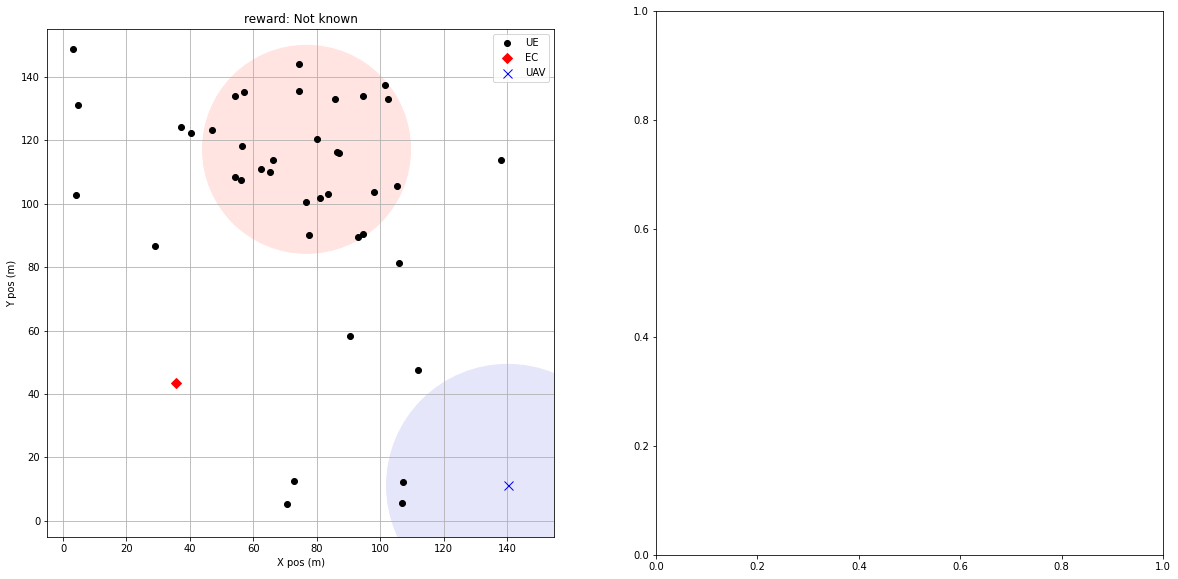

In [47]:
env.reset()
env.render()

In [32]:
# # This cell resets position of UAV initial state randomly without altering UE positions
# # Keep running this code cell till desired UAV initial state is achieved
# env.reset()
# env.current_state = env.initial_UAV_state = env.select_random_state()
# env.render()

## We set seeds and we get the necessary information on the states and actions in the chosen environment

In [33]:
# env.seed(seed)
torch.manual_seed(seed)
# np.random.seed(seed)
state_dim = env.state_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = env.action_space.high
min_action = env.action_space.low
# print(state_dim, action_dim, max_action, min_action)

## We create the policy network (the Actor model)

In [34]:
policy = TD3(state_dim, action_dim, max_action, min_action, critic_min_output, critic_max_output)

## We create the Experience Replay memory

In [35]:
policy.select_action(env.initial_UAV_state)

array([ 1.        , -0.8988862 ,  0.9999992 ,  0.99902534,  0.99996907,
       -0.7128041 ,  0.317342  ,  0.9926755 ,  0.84438217,  0.99998164,
       -0.9999919 ,  0.7236197 ,  0.9277767 , -0.9966623 , -0.9999998 ,
        0.9998424 ,  0.99997693,  0.98708546, -0.98619115,  0.34694597,
       -0.09188103,  0.9995257 , -0.99992675,  0.7184199 ,  0.99644935,
       -0.9975355 ,  1.        ,  0.9999998 ,  0.648296  ,  0.9999927 ,
       -0.9999823 ,  0.7568898 , -0.9963922 ,  0.9998291 ,  0.999802  ,
        0.9998096 ,  0.98469794, -0.57694477,  0.9420379 , -0.27587494,
       -0.996803  , -0.99985856, -0.8831915 ,  0.99992776], dtype=float32)

In [36]:
replay_buffer = ReplayBuffer()

## We define a list where all the evaluation results over 10 episodes are stored

In [37]:
evaluations_pre_post = evaluations = [evaluate_policy(policy)]

---------------------------------------
Average Reward over the Evaluation Step: 110.000000
---------------------------------------


In [38]:
# # Visualizing an episode using untrained actor network
# run_random_episode(policy)

## We create a new folder directory in which the final results (videos of the agent) will be populated

In [39]:
## NOT USED

# def mkdir(base, name):
#     path = os.path.join(base, name)
#     if not os.path.exists(path):
#         os.makedirs(path)
#     return path
# work_dir = mkdir('exp', 'brs')
# monitor_dir = mkdir(work_dir, 'monitor')
# max_episode_steps = env._max_episode_steps
# save_env_vid = False
# if save_env_vid:
#   env = wrappers.Monitor(env, monitor_dir, force = True)
#   env.reset()

## We initialize the variables

In [40]:
total_timesteps = 0
timesteps_since_eval = 0
episode_num = 0
done = True
t0 = time.time()
best_reward = -10000000
best_reward_episode_UAV_position_list = []
progressive_training_episodes_UAV_position_list = []
UAV_traversal_plot_episode_frequency = int(num_episodes // 10)

## Training

In [41]:
policy.select_action(env.initial_UAV_state)

array([ 1.        , -0.8988862 ,  0.9999992 ,  0.99902534,  0.99996907,
       -0.7128041 ,  0.317342  ,  0.9926755 ,  0.84438217,  0.99998164,
       -0.9999919 ,  0.7236197 ,  0.9277767 , -0.9966623 , -0.9999998 ,
        0.9998424 ,  0.99997693,  0.98708546, -0.98619115,  0.34694597,
       -0.09188103,  0.9995257 , -0.99992675,  0.7184199 ,  0.99644935,
       -0.9975355 ,  1.        ,  0.9999998 ,  0.648296  ,  0.9999927 ,
       -0.9999823 ,  0.7568898 , -0.9963922 ,  0.9998291 ,  0.999802  ,
        0.9998096 ,  0.98469794, -0.57694477,  0.9420379 , -0.27587494,
       -0.996803  , -0.99985856, -0.8831915 ,  0.99992776], dtype=float32)

Number of instances of a particular sample added to the Replay Buffer is proportional to the sample reward, and is given by the formula:- \
$instances = max(reward, 1)$ 

Streaming output truncated to the last 5000 lines.
Best Reward till now: 145.000000
----------------------reached training----------------------
critic loss:  tensor(18000.0215, device='cuda:0', grad_fn=<AddBackward0>)
actor loss:  tensor(-1000., device='cuda:0', grad_fn=<NegBackward0>)
Total Timesteps: 9376 Episode Num: 9376 Reward: 10
---------------------------------------
Average Reward over the Evaluation Step: 100.000000
---------------------------------------
Best Reward till now: 145.000000
----------------------reached training----------------------
critic loss:  tensor(9337.5273, device='cuda:0', grad_fn=<AddBackward0>)
actor loss:  tensor(-1000., device='cuda:0', grad_fn=<NegBackward0>)
Total Timesteps: 9377 Episode Num: 9377 Reward: 75
---------------------------------------
Average Reward over the Evaluation Step: 100.000000
---------------------------------------
Best Reward till now: 145.000000
----------------------reached training----------------------
critic loss:  te

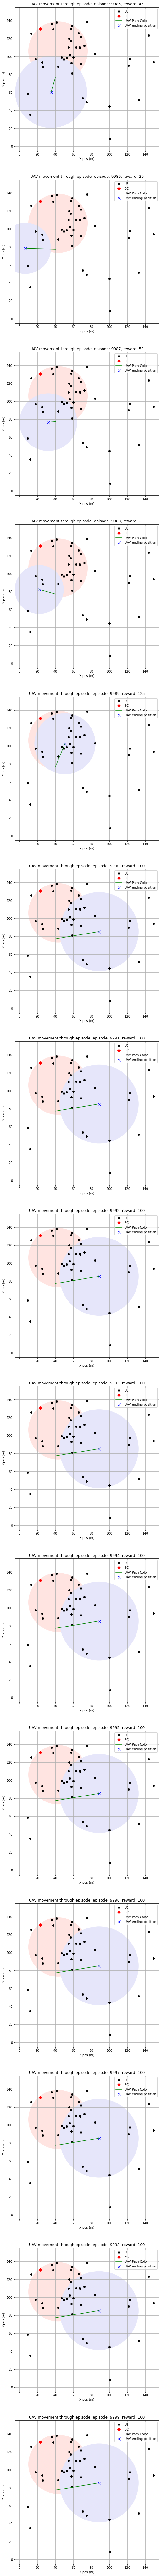

In [42]:
fig, axes = plt.subplots(15, figsize=(10, 150))
indx = 0
this_episode_UAV_positions_list = [env.initial_UAV_state]
boolean_last_episode_had_best_reward = False 
# We start the main loop over `max_timesteps` timesteps
while total_timesteps < max_timesteps:
  
  # If the episode is done
  if done:
    # print("here")
    if boolean_last_episode_had_best_reward:
        best_reward_episode_UAV_position_list = this_episode_UAV_positions_list
    
    boolean_last_episode_had_best_reward = False
    this_episode_UAV_positions_list = [env.initial_UAV_state]
    # If we are not at the very beginning, we start the training process of the model
    if total_timesteps != 0:
      # commenting for TESTING
      print("Total Timesteps: {} Episode Num: {} Reward: {}".format(total_timesteps, episode_num, episode_reward))
      # commenting for TESTING ends

    # We evaluate the episode and we save the policy
    if timesteps_since_eval >= eval_freq:
      # print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
      # print("total timesteps now: ", total_timesteps)
      # print("timesteps since last evaluation: ", timesteps_since_eval)
      # print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
      # timesteps_since_eval %= eval_freq
      evaluations.append(evaluate_policy(policy))
      
      print("Best Reward till now: %f" % (best_reward))

      policy.save(file_name, directory="./pytorch_models")
      np.save("./results/%s" % (file_name), evaluations)
    
    # When the training step is done, we reset the state of the environment
    obs = env.reset()
    
    # Set the Done to False
    done = False
    
    # Set rewards and episode timesteps to zero
    episode_reward = 0
    episode_timesteps = 0
    if(episode_num % UAV_traversal_plot_episode_frequency == 0):
        progressive_training_episodes_UAV_position_list.append(this_episode_UAV_positions_list)
    episode_num += 1
  
  # Before 10000 timesteps, we play random actions
  if total_timesteps < start_timesteps:
    action = env.action_space.sample()
  else: # After 10000 timesteps, we switch to the model
    action = policy.select_action(np.array(obs))
    # If the explore_noise parameter is not 0, we add noise to the action and we clip it
    if expl_noise != 0:
      action = (action + np.random.normal(0, expl_noise, size=env.action_space.shape[0])).clip(env.action_space.low, env.action_space.high)
  
  # The agent performs the action in the environment, then reaches the next state and receives the reward
  done_bool = 0 if episode_timesteps + 1 == max_episode_steps else float(done)
  new_obs, reward, done, _ = env.step(action)
  replay_buffer.add((obs, new_obs, action, reward, done_bool), num_instances = max(reward, 1))
  obs = new_obs
  episode_timesteps += 1
  timesteps_since_eval += 1
  total_timesteps += 1
  policy.train(replay_buffer, episode_timesteps, batch_size, discount, tau, policy_noise, noise_clip, policy_freq)
  this_episode_UAV_positions_list.append(new_obs)
  if best_reward < reward:
  #     boolean_last_episode_had_best_reward = True
      best_reward = max(best_reward, reward)
  #     env.render(fig = fig, ax = axes, i = indx, reward = str(best_reward) + ', episode number: ' + str(episode_num))
  #     indx += 1
  # env.render(fig = fig, ax = axes, i = indx, reward = str(best_reward) + ', episode number: ' + str(episode_num))
  
  # Commented for TESTING
  if start_timesteps - total_timesteps < 5:
    env.render(UAV_positions_list = this_episode_UAV_positions_list, fig = fig, ax = axes, i = indx, episode_num = str(episode_num - 1) + ', reward: ' + str(reward))
    # env.render(fig = fig, ax = axes, i = indx, reward = str(reward) + ', episode number: ' + str(episode_num))
    indx += 1
  # End of commented for TESTING

  # We check if the episode is done
  
  # We increase the total reward
  episode_reward += reward
  
  # We store the new transition into the Experience Replay memory (ReplayBuffer)

  # We update the state, the episode timestep, the total timesteps, and the timesteps since the evaluation of the policy

# We add the last policy evaluation to our list of evaluations and we save our model
evaluations.append(evaluate_policy(policy))
print("Best Reward till now: %f" % (best_reward))
if save_models: policy.save("%s" % (file_name), directory="./pytorch_models")
np.save("./results/%s" % (file_name), evaluations)

In [43]:
policy.select_action(env.initial_UAV_state)

array([ 1.        , -0.94789517,  0.99999964,  0.9995229 ,  0.9999606 ,
        0.7820693 , -0.8056387 ,  0.99617696,  0.963273  ,  0.999947  ,
       -0.99999374,  0.9091524 ,  0.9701286 , -0.995623  , -0.9999997 ,
        0.99984413,  0.99999094,  0.99419785, -0.9862252 , -0.8567441 ,
        0.74803054,  0.99954313, -0.6606108 , -0.8407912 ,  0.99076694,
       -0.9995733 ,  1.        ,  0.9999999 ,  0.6370473 ,  0.99998826,
       -0.99998736, -0.8753485 , -0.9987099 ,  0.99952716,  0.9997919 ,
        0.9998143 ,  0.99615705,  0.7547075 ,  0.9428501 ,  0.72964525,
       -0.98476493, -0.99923664, -0.9548146 ,  0.99995905], dtype=float32)

---------------------------------------
Average Reward over the Evaluation Step: 32.000000
---------------------------------------
Best Reward till now: -10000000.000000


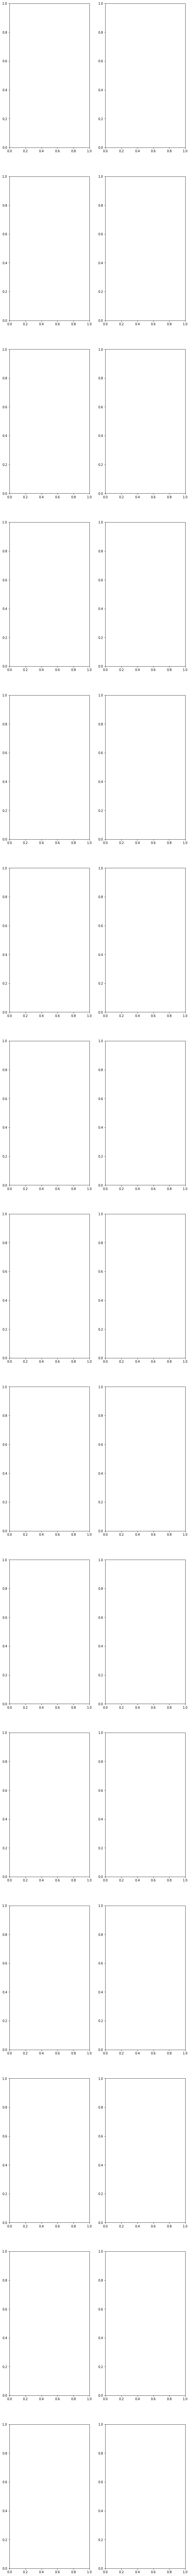

In [ ]:
fig, axes = plt.subplots(15, 2, figsize=(10, 150))
indx = 0
this_episode_UAV_positions_list = []
boolean_last_episode_had_best_reward = False 
# We start the main loop over `max_timesteps` timesteps
while total_timesteps < max_timesteps:
  
  # If the episode is done
  if done:
    if boolean_last_episode_had_best_reward:
        best_reward_episode_UAV_position_list = this_episode_UAV_positions_list
    
    boolean_last_episode_had_best_reward = False
    this_episode_UAV_positions_list = []
    # If we are not at the very beginning, we start the training process of the model
    if total_timesteps != 0:
      # commenting for TESTING
      print("Total Timesteps: {} Episode Num: {} Reward: {}".format(total_timesteps, episode_num, episode_reward))
      # commenting for TESTING ends
      policy.train(replay_buffer, episode_timesteps, batch_size, discount, tau, policy_noise, noise_clip, policy_freq)

    # We evaluate the episode and we save the policy
    if timesteps_since_eval >= eval_freq:
      # print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
      # print("total timesteps now: ", total_timesteps)
      # print("timesteps since last evaluation: ", timesteps_since_eval)
      # print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
      # timesteps_since_eval %= eval_freq
      evaluations.append(evaluate_policy(policy))
      
      print("Best Reward till now: %f" % (best_reward))

      policy.save(file_name, directory="./pytorch_models")
      np.save("./results/%s" % (file_name), evaluations)
    
    # When the training step is done, we reset the state of the environment
    obs = env.reset()
    
    # Set the Done to False
    done = False
    
    # Set rewards and episode timesteps to zero
    episode_reward = 0
    episode_timesteps = 0
    if(episode_num % UAV_traversal_plot_episode_frequency == 0):
        progressive_training_episodes_UAV_position_list.append(this_episode_UAV_positions_list)
    episode_num += 1
  
  # Before 10000 timesteps, we play random actions
  if total_timesteps < start_timesteps:
    action = env.action_space.sample()
  else: # After 10000 timesteps, we switch to the model
    action = policy.select_action(np.array(obs))
    # If the explore_noise parameter is not 0, we add noise to the action and we clip it
    if expl_noise != 0:
      action = (action + np.random.normal(0, expl_noise, size=env.action_space.shape[0])).clip(env.action_space.low, env.action_space.high)
  
  # The agent performs the action in the environment, then reaches the next state and receives the reward
  new_obs, reward, done, _ = env.step(action)
  this_episode_UAV_positions_list.append(new_obs)
  if best_reward < reward:
      boolean_last_episode_had_best_reward = True
      best_reward = max(best_reward, reward)
      env.render(fig = fig, ax = axes, i = indx, reward = str(best_reward) + ', episode number: ' + str(episode_num))
      indx += 1
  
  # We check if the episode is done
  done_bool = 0 if episode_timesteps + 1 == max_episode_steps else float(done)
  
  # We increase the total reward
  episode_reward += reward
  
  # We store the new transition into the Experience Replay memory (ReplayBuffer)
  replay_buffer.add((obs, new_obs, action, reward, done_bool), num_instances = max(reward, 1))

  # We update the state, the episode timestep, the total timesteps, and the timesteps since the evaluation of the policy
  obs = new_obs
  episode_timesteps += 1
  total_timesteps += 1
  timesteps_since_eval += 1

# We add the last policy evaluation to our list of evaluations and we save our model
evaluations.append(evaluate_policy(policy))
print("Best Reward till now: %f" % (best_reward))
if save_models: policy.save("%s" % (file_name), directory="./pytorch_models")
np.save("./results/%s" % (file_name), evaluations)

In [ ]:
# print(len(best_reward_episode_UAV_position_list))

In [ ]:
# Plotting the UAV's trajectory through the episode that yielded the best reward configuration 
env.render(UAV_positions_list = best_reward_episode_UAV_position_list)

In [ ]:
num_subplots = len(progressive_training_episodes_UAV_position_list)
fig, axes = plt.subplots(num_subplots, figsize=(10, num_subplots * 10))
for i_ in range(num_subplots):
    env.render(UAV_positions_list = progressive_training_episodes_UAV_position_list[i_], fig = fig, ax = axes, i = i_, episode_num = (i_ * UAV_traversal_plot_episode_frequency))

In [ ]:
run_random_episode(policy)

In [ ]:
# This cell compares the evaluation reward before training vs after training
evaluations_pre_post.append(evaluate_policy(policy))
print("average evaluation reward before training: ", evaluations_pre_post[0])
print("average evaluation reward after training: ", evaluations_pre_post[-1])

We can see that the rewards are distinct, indicating that the network weights are actually being updated

## Inference

In [ ]:
class Actor(nn.Module):
  
  def __init__(self, state_dim, action_dim, max_action):
    super(Actor, self).__init__()
    self.layer_1 = nn.Linear(state_dim, 400)
    self.layer_2 = nn.Linear(400, 300)
    self.layer_3 = nn.Linear(300, action_dim)
    self.max_action = max_action

  def forward(self, x):
    x = F.relu(self.layer_1(x))
    x = F.relu(self.layer_2(x))
    x = self.max_action * torch.tanh(self.layer_3(x)) 
    return x

class Critic(nn.Module):
  
  def __init__(self, state_dim, action_dim):
    super(Critic, self).__init__()
    # Defining the first Critic neural network
    self.layer_1 = nn.Linear(state_dim + action_dim, 400)
    self.layer_2 = nn.Linear(400, 300)
    self.layer_3 = nn.Linear(300, 1)
    # Defining the second Critic neural network
    self.layer_4 = nn.Linear(state_dim + action_dim, 400)
    self.layer_5 = nn.Linear(400, 300)
    self.layer_6 = nn.Linear(300, 1)

  def forward(self, x, u):
    xu = torch.cat([x, u], 1)
    # Forward-Propagation on the first Critic Neural Network
    x1 = F.relu(self.layer_1(xu))
    x1 = F.relu(self.layer_2(x1))
    x1 = self.layer_3(x1)
    # Forward-Propagation on the second Critic Neural Network
    x2 = F.relu(self.layer_4(xu))
    x2 = F.relu(self.layer_5(x2))
    x2 = self.layer_6(x2)
    return x1, x2

  def Q1(self, x, u):
    xu = torch.cat([x, u], 1)
    x1 = F.relu(self.layer_1(xu))
    x1 = F.relu(self.layer_2(x1))
    x1 = self.layer_3(x1)
    return x1

# Selecting the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Building the whole Training Process into a class

class TD3(object):
  
  def __init__(self, state_dim, action_dim, max_action):
    self.actor = Actor(state_dim, action_dim, max_action).to(device)
    self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
    self.actor_target.load_state_dict(self.actor.state_dict())
    self.actor_optimizer = torch.optim.Adam(self.actor.parameters())
    self.critic = Critic(state_dim, action_dim).to(device)
    self.critic_target = Critic(state_dim, action_dim).to(device)
    self.critic_target.load_state_dict(self.critic.state_dict())
    self.critic_optimizer = torch.optim.Adam(self.critic.parameters())
    self.max_action = max_action

  def select_action(self, state):
    state = torch.Tensor(state.reshape(1, -1)).to(device)
    return self.actor(state).cpu().data.numpy().flatten()

  def train(self, replay_buffer, iterations, batch_size=100, discount=0.99, tau=0.005, policy_noise=0.2, noise_clip=0.5, policy_freq=2):
    
    for it in range(iterations):
      
      # Step 4: We sample a batch of transitions (s, s’, a, r) from the memory
      batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones = replay_buffer.sample(batch_size)
      state = torch.Tensor(batch_states).to(device)
      next_state = torch.Tensor(batch_next_states).to(device)
      action = torch.Tensor(batch_actions).to(device)
      reward = torch.Tensor(batch_rewards).to(device)
      done = torch.Tensor(batch_dones).to(device)
      
      # Step 5: From the next state s’, the Actor target plays the next action a’
      next_action = self.actor_target(next_state)
      
      # Step 6: We add Gaussian noise to this next action a’ and we clamp it in a range of values supported by the environment
      noise = torch.Tensor(batch_actions).data.normal_(0, policy_noise).to(device)
      noise = noise.clamp(-noise_clip, noise_clip)
      next_action = (next_action + noise).clamp(-self.max_action, self.max_action)
      
      # Step 7: The two Critic targets take each the couple (s’, a’) as input and return two Q-values Qt1(s’,a’) and Qt2(s’,a’) as outputs
      target_Q1, target_Q2 = self.critic_target(next_state, next_action)
      
      # Step 8: We keep the minimum of these two Q-values: min(Qt1, Qt2)
      target_Q = torch.min(target_Q1, target_Q2)
      
      # Step 9: We get the final target of the two Critic models, which is: Qt = r + γ * min(Qt1, Qt2), where γ is the discount factor
      target_Q = reward + ((1 - done) * discount * target_Q).detach()
      
      # Step 10: The two Critic models take each the couple (s, a) as input and return two Q-values Q1(s,a) and Q2(s,a) as outputs
      current_Q1, current_Q2 = self.critic(state, action)
      
      # Step 11: We compute the loss coming from the two Critic models: Critic Loss = MSE_Loss(Q1(s,a), Qt) + MSE_Loss(Q2(s,a), Qt)
      critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)
      
      # Step 12: We backpropagate this Critic loss and update the parameters of the two Critic models with a SGD optimizer
      self.critic_optimizer.zero_grad()
      critic_loss.backward()
      self.critic_optimizer.step()
      
      # Step 13: Once every two iterations, we update our Actor model by performing gradient ascent on the output of the first Critic model
      if it % policy_freq == 0:
        actor_loss = -self.critic.Q1(state, self.actor(state)).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # Step 14: Still once every two iterations, we update the weights of the Actor target by polyak averaging
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
          target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
        
        # Step 15: Still once every two iterations, we update the weights of the Critic target by polyak averaging
        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
          target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
  
  # Making a save method to save a trained model
  def save(self, filename, directory):
    torch.save(self.actor.state_dict(), '%s/%s_actor.pth' % (directory, filename))
    torch.save(self.critic.state_dict(), '%s/%s_critic.pth' % (directory, filename))
  
  # Making a load method to load a pre-trained model
  def load(self, filename, directory):
    self.actor.load_state_dict(torch.load('%s/%s_actor.pth' % (directory, filename)))
    self.critic.load_state_dict(torch.load('%s/%s_critic.pth' % (directory, filename)))

def evaluate_policy(policy, eval_episodes=10):
  avg_reward = 0.
  for _ in range(eval_episodes):
    obs = env.reset()
    done = False
    while not done:
      action = policy.select_action(np.array(obs))
      obs, reward, done, _ = env.step(action)
      avg_reward += reward
  avg_reward /= eval_episodes
  print ("---------------------------------------")
  print ("Average Reward over the Evaluation Step: %f" % (avg_reward))
  print ("---------------------------------------")
  return avg_reward

env_name = "HalfCheetahBulletEnv-v0"
seed = 0

file_name = "%s_%s_%s" % ("TD3", env_name, str(seed))
print ("---------------------------------------")
print ("Settings: %s" % (file_name))
print ("---------------------------------------")

eval_episodes = 10
# save_env_vid = True
env = gym.make(env_name)
max_episode_steps = env._max_episode_steps
# if save_env_vid:
#   env = wrappers.Monitor(env, monitor_dir, force = True)
#   env.reset()
env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])
policy = TD3(state_dim, action_dim, max_action)
policy.load(file_name, './pytorch_models/')
_ = evaluate_policy(policy, eval_episodes=eval_episodes)

---------------------------------------
Settings: TD3_HalfCheetahBulletEnv-v0_0
---------------------------------------


FileNotFoundError: ignored

In [ ]:
np.load('results/TD3_HalfCheetahBulletEnv-v0_0.npy')

## Testing the Environment

In [ ]:
obj1 = Single_Agent_UAV()

UE positions:  [[54.35376114 55.99166477  0.        ]
 [10.14254108  7.16943038  0.        ]
 [45.30858012 48.09036623  0.        ]
 [55.47647174 27.52536019  0.        ]
 [48.7308606  51.15937027  0.        ]]
D_m array:  [2746138 3669390 2686372 1886120 4082719]
C_m array:  [128 157 128 155 197]
EC positions:  [[41.88348475 43.55857918  0.        ]]
Computation resource at ECs F^e_k:  [8393880710]
initial state of UAV:  [49.77613488 22.74202633 32.89648829]


In [ ]:
action = obj1.action_space.sample()
obj1.step(action)

current state before moving:  [30.10190021 53.35031999 43.37526131]
horizontal direction angle:  1.202695608139038
new state after move:  [ 0.        60.        43.2236653]
action:  [46.115753    2.9937944  -0.15159601  4.2502594   0.08178703  0.08880728
  0.6835574   0.8782801   0.62439686]
gamma zeros:  [0.91821295 0.9111927  0.3164426  0.1217199  0.37560314]
horizontal distance b/w UEs and UAV:  [54.50135871 53.79535506 46.84769801 64.28251043 49.52629109]
distance b/w UEs and UAV:  [69.56064507 69.00887963 63.74160376 77.46306468 65.7353691 ]
M_t:  1  C_max_t:  47.26963761756768
distance b/w ECs and UAV:  [62.3925625]
-------displaying stats for UAV-1:------- 
h_m:  2.0666779143659992e-09
R_m:  110137957.5680606
D_array:  2746138 (5,)
R_m:  110137957.5680606 (5,)
printing array division:  [0.02493362 0.03324698 0.02384547 0.01762154 0.03652811]
T_G2A_t:  0.024933620167261614
f_i:  3000000000.0
rho_array:  [0 0 1 0 0]
T_G2A_t_list [0.02493362 0.03324698 0.02384547 0.01762154 0.03652

(array([ 0.       , 60.       , 43.2236653]), -20, False, None)

In [ ]:
obj1.timesteps_in_episode

8

In [ ]:
a_space = gym.spaces.box.Box(low = np.array([-2, -100]), high = np.array([-1, -50]))
a_space.sample()

In [ ]:
[47.06536908 66.48387642

In [ ]:
obj1.current_state

In [ ]:
a[2] = 4
obj1.step(a)

In [ ]:
obj1.timesteps_in_episode

1

In [ ]:
obj1.current_state[:2] = np.zeros(2)

In [ ]:
a = np.array([64.52, 261.24])
b = np.array([65.06030231, 262.08147098])
np.linalg.norm(obj1.current_state-obj1.previous_state)

24.99999999999997

## To-Do 

In [ ]:
# To-Do:
# 1. Take care of units
# 2. How to reward cases having (sum of gamma != 1)?
# 3. Hyperparameters?
# 4. D_m should be integer or not?
# 5. Efficient algorithm to print penalties?
# 6. Convert everything to numpy.
# 7. How to get kappa? (given in paper, now confirm if the precision holds)
# 8. Complete move() and step() functions (reward calculation part left).
# 9. C_max_t formula is not correct in the paper. Change it in the code. (IMP) (change made)
# 10. Should we truncate? Right now, no truncation is being made.
# 11. Fix units (MHz, GHz, Mbits, bits) (understood now, doing it now)
# 12. Script dB to Power Gain converter and dBm to watt converter
# 13. Separate environment parameters and training parameters
# 14. Make a function in the environment to generate fabricated positions of UEs (to better monitor model training)

# Kachra

In [ ]:
point1 = np.array((1, 2, 3))
point2 = np.array((1, 1, 1))
 
# calculating Euclidean distance
# using linalg.norm()
dist = np.linalg.norm(point1 - point2)

In [ ]:
type(dist)

numpy.float64

In [ ]:
type(np.radians(90.))

numpy.float64

In [ ]:
a = np.array([[1, 2, 3], [4, 5, 6]])
a = np.array(a)
b = np.array([2, 3, 4])
a/b

array([[0.5       , 0.66666667, 0.75      ],
       [2.        , 1.66666667, 1.5       ]])

In [ ]:
a = np.array([1, 4, 3])
b = np.array([2, 2, 2])
a*b

array([2, 8, 6])

In [ ]:
a = np.array([[3, 4, 2],
[4, 5, 7]])
b = np.array([2, 1, 3])
a/b

array([[1.5       , 4.        , 0.66666667],
       [2.        , 5.        , 2.33333333]])

In [ ]:
a=np.arange(20).reshape((5,4))
print(a)
b=np.array([2, 1, 3, 4, 5])
print(b)
c=a / (b)[:, np.newaxis]
print(c)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]
 [16 17 18 19]]
[2 1 3 4 5]
[[0.         0.5        1.         1.5       ]
 [4.         5.         6.         7.        ]
 [2.66666667 3.         3.33333333 3.66666667]
 [3.         3.25       3.5        3.75      ]
 [3.2        3.4        3.6        3.8       ]]


In [ ]:
for current_UE in self.UE_positions:
    dist_i = np.linalg.norm(current_UE - self.current_state)
    dist_UE_UAV.append(dist_i)
    if(np.square(C_max_t) >= dist_i):
        M_t += 1

for current_EC in self.EC_positions:
    dist_i = np.linalg.norm(current_EC - self.current_state) 
    dist_EC_UAV.append(dist_i)

dist_UE_UAV = np.array(dist_UE_UAV)
dist_EC_UAV = np.array(dist_EC_UAV)

In [ ]:
a = np.arange(20).reshape((5, 4))
print(a)
b = np.array([3, 1, 2, 1])
c = a-b
print(c)
d = np.linalg.norm(c, axis = 1)
e = 3
f = (((d <= np.square(e)))*1).sum()

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]
 [16 17 18 19]]
[[-3  0  0  2]
 [ 1  4  4  6]
 [ 5  8  8 10]
 [ 9 12 12 14]
 [13 16 16 18]]


numpy.int32

In [ ]:
a = [2., 1., 3., 5, 10, 4, 7, 9, 11, 8]
b = (np.array(a[2:])).reshape((4, 2))
print(b)
c = b.sum(axis = 1)
print(c)
d = [1, 2, 3, 4]
print(c * d)
(c+d).shape

[[ 3.  5.]
 [10.  4.]
 [ 7.  9.]
 [11.  8.]]
[ 8. 14. 16. 19.]
[ 8. 28. 48. 76.]


(4,)

In [ ]:
a = np.array([2, 8])
b = np.array([3, 1])
np.maximum(a, b)

array([3, 8])

In [ ]:
a = np.array([[2, 3], [8, 11], [13, 4]])
b = np.array([[5, 1], [4, 13], [15, 2]])
c= (a+b)
print(c)
c.max(axis=1)

[[ 7  4]
 [12 24]
 [28  6]]


array([ 7, 24, 28])

In [ ]:
a = np.ones(5) - 0.3
type(a[0])

numpy.float64

In [ ]:

np.clip(a, 0, 1)

array([[1, 1, 1],
       [1, 1, 1]])

In [ ]:
a = np.array([2, 3, 4, 5, 6, 7, 8])
b = np.array([[2, 3, 4], [5, 4, 2]])
a[1:] = b.flatten()
print(a, type(b))

[2 2 3 4 5 4 2] <class 'numpy.ndarray'>


In [ ]:
a = input()
print(type(a))

1
<class 'str'>


In [ ]:
a = np.array([1, 2, 3, 4])
a[0:4] = [2, 3, 4, 5]
a

array([2, 3, 4, 5])

In [ ]:
a = np.array([2, 3, 6, 7])
b = np.array([4, 1, 4, 5])
c = a/b
c

array([0.5, 3. , 1.5, 1.4])

In [ ]:
import math
import warnings
from typing import TYPE_CHECKING, Optional

import numpy as np

import gym
from gym import error, spaces
from gym.error import DependencyNotInstalled
from gym.utils import EzPickle, colorize
# from gym.utils.step_api_compatibility import step_api_compatibility

In [ ]:
class HalfCheetahEnv(MuJocoPyEnv, utils.EzPickle):
    metadata = {
        "render_modes": [
            "human",
            "rgb_array",
            "depth_array",
        ],
        "render_fps": 20,
    }

    def __init__(self, **kwargs):
        observation_space = Box(low=-np.inf, high=np.inf, shape=(17,), dtype=np.float64)
        MuJocoPyEnv.__init__(
            self, "half_cheetah.xml", 5, observation_space=observation_space, **kwargs
        )
        utils.EzPickle.__init__(self, **kwargs)

    def step(self, action):
        xposbefore = self.sim.data.qpos[0]
        self.do_simulation(action, self.frame_skip)
        xposafter = self.sim.data.qpos[0]

        ob = self._get_obs()
        reward_ctrl = -0.1 * np.square(action).sum()
        reward_run = (xposafter - xposbefore) / self.dt
        reward = reward_ctrl + reward_run
        terminated = False

        if self.render_mode == "human":
            self.render()
        return (
            ob,
            reward,
            terminated,
            False,
            dict(reward_run=reward_run, reward_ctrl=reward_ctrl),
        )

    def _get_obs(self):
        return np.concatenate(
            [
                self.sim.data.qpos.flat[1:],
                self.sim.data.qvel.flat,
            ]
        )

    def reset_model(self):
        qpos = self.init_qpos + self.np_random.uniform(
            low=-0.1, high=0.1, size=self.model.nq
        )
        qvel = self.init_qvel + self.np_random.standard_normal(self.model.nv) * 0.1
        self.set_state(qpos, qvel)
        return self._get_obs()

    def viewer_setup(self):
        assert self.viewer is not None
        self.viewer.cam.distance = self.model.stat.extent * 0.5